In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
import csv
import os
import matplotlib.pyplot as plt


In [2]:

def safe_float(val):
    try:
        val = str(val).strip().replace("<", "").replace(">", "")
        return float(val)
    except:
        return None

def to_p(x): return -np.log10(x / 1e9) if x > 0 else None

ki = pd.read_csv("/home/amit/Aging_project/gf-ki.txt", sep="\t")
kd = pd.read_csv("/home/amit/Aging_project/gf-kd.txt", sep="\t")
ic50 = pd.read_csv("/home/amit/Aging_project/gf-ic50.txt", sep="\t")
ec50 = pd.read_csv("/home/amit/Aging_project/gf-ec50.txt", sep="\t", on_bad_lines='skip')

ki.columns = ["DrugID", "ProteinID", "Ki"]
kd.columns = ["DrugID", "ProteinID", "Kd"]
ic50.columns = ["DrugID", "ProteinID", "IC50"]
ec50.columns = ["DrugID", "ProteinID", "EC50"]

ki_map = {(r.DrugID, r.ProteinID): safe_float(r.Ki) for _, r in ki.iterrows()}
kd_map = {(r.DrugID, r.ProteinID): safe_float(r.Kd) for _, r in kd.iterrows()}
ic50_map = {(r.DrugID, r.ProteinID): safe_float(r.IC50) for _, r in ic50.iterrows()}

pair_counts = defaultdict(int)
for d in [ki_map, kd_map, ic50_map]:
    for k in d:
        if d[k]: pair_counts[k] += 1

pairs_3d = [k for k in pair_counts if k in ki_map and k in kd_map and k in ic50_map]
data_records = []
for k in pairs_3d:
    pk, p_d, pi = to_p(ki_map[k]), to_p(kd_map[k]), to_p(ic50_map[k])
    if None not in (pk, p_d, pi):
        data_records.append([pi, pk, p_d])
df_3d = pd.DataFrame(data_records, columns=["pIC50", "pKi", "pKd"])

def extract_anchors():
    xy, yz, zx = [], [], []
    for k in pair_counts:
        pk, p_d, pi = to_p(ki_map.get(k, -1)), to_p(kd_map.get(k, -1)), to_p(ic50_map.get(k, -1))
        if pk and pi and not p_d:
            xy.append([pi, pk])
        if pk and p_d and not pi:
            yz.append([pk, p_d])
        if pi and p_d and not pk:
            zx.append([pi, p_d])
    return np.array(xy), np.array(yz), np.array(zx)

anchor_xy, anchor_yz, anchor_zx = extract_anchors()

class AffinityDataset(Dataset):
    def __init__(self, df):
        self.data = torch.tensor(df.values, dtype=torch.float32)
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

train_df, test_df = train_test_split(df_3d, test_size=0.2, random_state=42)
train_dataset = AffinityDataset(train_df)
test_dataset = AffinityDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class ProjectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(3, 16), nn.ReLU(), nn.Linear(16, 8), nn.ReLU())
        self.head_xy = nn.Linear(8, 2)
        self.head_yz = nn.Linear(8, 2)
        self.head_zx = nn.Linear(8, 2)
        self.log_lambda = nn.Parameter(torch.tensor(0.0))
        self.log_alpha = nn.Parameter(torch.tensor(0.0))
        self.log_beta = nn.Parameter(torch.tensor(0.0))
        self.log_gamma = nn.Parameter(torch.tensor(0.0))
        self.log_triplet = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        h = self.encoder(x)
        return self.head_xy(h), self.head_yz(h), self.head_zx(h)


# If two points Q₁ and Q₂ in the original 3D space are close (i.e., ||Q₂ - Q₁|| is small), 
# then their 2D projections (on XY, YZ, and XZ planes) should also be close
# If dist3d.mean() will be small.
# The model will be penalized more if the projections (px, py, pz) differ a lot.
def projection_consistency(px, py, pz, idx, jdx, original_batch):
    p_i = original_batch[idx]  
    p_j = original_batch[jdx]  
    dist3d = F.pairwise_distance(p_i, p_j)  

    loss = F.mse_loss(px[idx], px[jdx]) + \
           F.mse_loss(py[idx], py[jdx]) + \
           F.mse_loss(pz[idx], pz[jdx])

    return loss / (dist3d.mean() + 1e-6)


# Computes one normal per sample using cross product of lifted 3D points.
# Normalizes each vector, making it comparable.
# Computes average cosine similarity of adjacent normals.
# Loss = 1 - mean cosine, which penalizes changes in plane orientation.

# def plane_similarity(px, py, pz):
#     normals = []
#     for i in range(px.shape[0]):
#         Q1 = torch.tensor([px[i,0], px[i,1], 0.0])
#         Q2 = torch.tensor([0.0, py[i,0], py[i,1]])
#         Q3 = torch.tensor([pz[i,0], 0.0, pz[i,1]])
#         n = torch.cross(Q2 - Q1, Q3 - Q1)
#         normals.append(F.normalize(n, dim=0))
#     normals = torch.stack(normals)
#     return 1 - F.cosine_similarity(normals[:-1], normals[1:], dim=1).mean()

def plane_similarity(px, py, pz, original_batch):
    normals_pred = []
    normals_true = []

    for i in range(px.shape[0]):
        x, y, z = original_batch[i]

        # projected planes
        Q1_pred = torch.tensor([px[i,0], px[i,1], 0.0], device=px.device)
        Q2_pred = torch.tensor([0.0, py[i,0], py[i,1]], device=px.device)
        Q3_pred = torch.tensor([pz[i,0], 0.0, pz[i,1]], device=px.device)
        n_pred = torch.cross(Q2_pred - Q1_pred, Q3_pred - Q1_pred)
        normals_pred.append(F.normalize(n_pred, dim=0))

        # 3D coordinate from original points
        Q1_true = torch.tensor([x, y, 0.0], device=px.device)
        Q2_true = torch.tensor([0.0, y, z], device=px.device)
        Q3_true = torch.tensor([x, 0.0, z], device=px.device)
        n_true = torch.cross(Q2_true - Q1_true, Q3_true - Q1_true)
        normals_true.append(F.normalize(n_true, dim=0))

    normals_pred = torch.stack(normals_pred)
    normals_true = torch.stack(normals_true)
    return 1 - torch.abs(F.cosine_similarity(normals_pred, normals_true, dim=1)).mean()


# label = 1: enforces similar pairs to stay close.
# label = 0: enforces dissimilar pairs to be separated by at least margin
def contrastive_all(px, py, pz, idx, jdx, label, margin=1.0):
    loss = 0
    for proj in [px, py, pz]:
        d = F.pairwise_distance(proj[idx], proj[jdx])
        loss += torch.mean(label * d**2 + (1 - label) * F.relu(margin - d)**2)
    return loss / 3

# Ensures number of samples is divisible by 3
# Applies triplet loss independently across px, py, pz and averages
# Margin encourages anchor-closer-to-positive than negative by at least margin
def triplet_loss_all(px, py, pz, margin=1.0):
    def _triplet(proj):
        N = proj.shape[0] - (proj.shape[0] % 3)  # Make it divisible by 3
        proj = proj[:N]
        anchor = proj[::3]
        positive = proj[1::3]
        negative = proj[2::3]
        return F.relu((anchor - positive).pow(2).sum(1) - (anchor - negative).pow(2).sum(1) + margin).mean()
    return sum([_triplet(proj) for proj in [px, py, pz]]) / 3


def jacobian_loss(model, x):
    x.requires_grad_(True)
    out = model.encoder(x)
    loss = 0.0
    for i in range(out.shape[1]):
        grad = torch.autograd.grad(out[:, i].sum(), x, create_graph=True)[0]
        loss += torch.norm(grad, p='fro')**2
    return loss / x.shape[0]

def anchor_loss(proj, true_pairs, anchors, sigma=1):
    loss, count = 0.0, 0
    for i in range(true_pairs.size(0)):
        dists = np.linalg.norm(anchors - true_pairs[i].detach().numpy(), axis=1)
        weights = np.exp(-dists**2 / sigma**2)
        top_idx = np.argsort(weights)[-2:]
        for j in top_idx:
            loss += weights[j] * F.mse_loss(proj[i], torch.tensor(anchors[j], dtype=torch.float32))
            count += 1
    return loss / count if count > 0 else torch.tensor(0.0)

model = ProjectionModel()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(201):
    model.train()
    total_loss = 0
    for batch in train_loader:
        opt.zero_grad()
        px, py, pz = model(batch)

        B = len(batch)
        idx = np.random.choice(B, B//2, replace=False)
        jdx = np.random.choice(B, B//2, replace=False)
        lbl = torch.tensor([1 if i % 2 == 0 else 0 for i in range(len(idx))], dtype=torch.float32)

        # loss_proj = projection_consistency(px, py, pz, idx, jdx)
        loss_proj = projection_consistency(px, py, pz, idx, jdx, batch)
        loss_plane = plane_similarity(px, py, pz, batch)
        loss_contrast = contrastive_all(px, py, pz, idx, jdx, lbl)
        loss_anchor = anchor_loss(px, batch[:, [0, 1]], anchor_xy) + \
                      anchor_loss(py, batch[:, [1, 2]], anchor_yz) + \
                      anchor_loss(pz, batch[:, [0, 2]], anchor_zx)
        loss_jac = jacobian_loss(model, batch)
        loss_triplet = triplet_loss_all(px, py, pz)

        λ = F.softplus(model.log_lambda)
        α = F.softplus(model.log_alpha)
        β = F.softplus(model.log_beta)
        γ = F.softplus(model.log_gamma)
        τ = F.softplus(model.log_triplet)

        loss = loss_proj + λ * loss_contrast + α * loss_anchor + β * loss_plane + γ * loss_jac + τ * loss_triplet
        loss.backward()
        opt.step()
        total_loss += loss.item()

    if epoch % 25 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss:.4f} | λ={λ.item():.4f} α={α.item():.4f} β={β.item():.4f} γ={γ.item():.4f} τ={τ.item():.4f}")


Epoch 0: Total Loss = 902.5910 | λ=0.6494 α=0.6498 β=0.6507 γ=0.6493 τ=0.6491
Epoch 25: Total Loss = 34.6671 | λ=0.1935 α=0.4880 β=0.5047 γ=0.2183 τ=0.1805
Epoch 50: Total Loss = 24.6908 | λ=0.1139 α=0.3613 β=0.4138 γ=0.1382 τ=0.0979
Epoch 75: Total Loss = 18.3820 | λ=0.0773 α=0.2541 β=0.3300 γ=0.0873 τ=0.0622
Epoch 100: Total Loss = 13.6872 | λ=0.0582 α=0.1748 β=0.2602 γ=0.0592 τ=0.0439
Epoch 125: Total Loss = 9.7031 | λ=0.0472 α=0.1204 β=0.2020 γ=0.0448 τ=0.0330
Epoch 150: Total Loss = 7.2914 | λ=0.0394 α=0.0848 β=0.1573 γ=0.0374 τ=0.0257
Epoch 175: Total Loss = 5.5411 | λ=0.0333 α=0.0614 β=0.1232 γ=0.0332 τ=0.0203


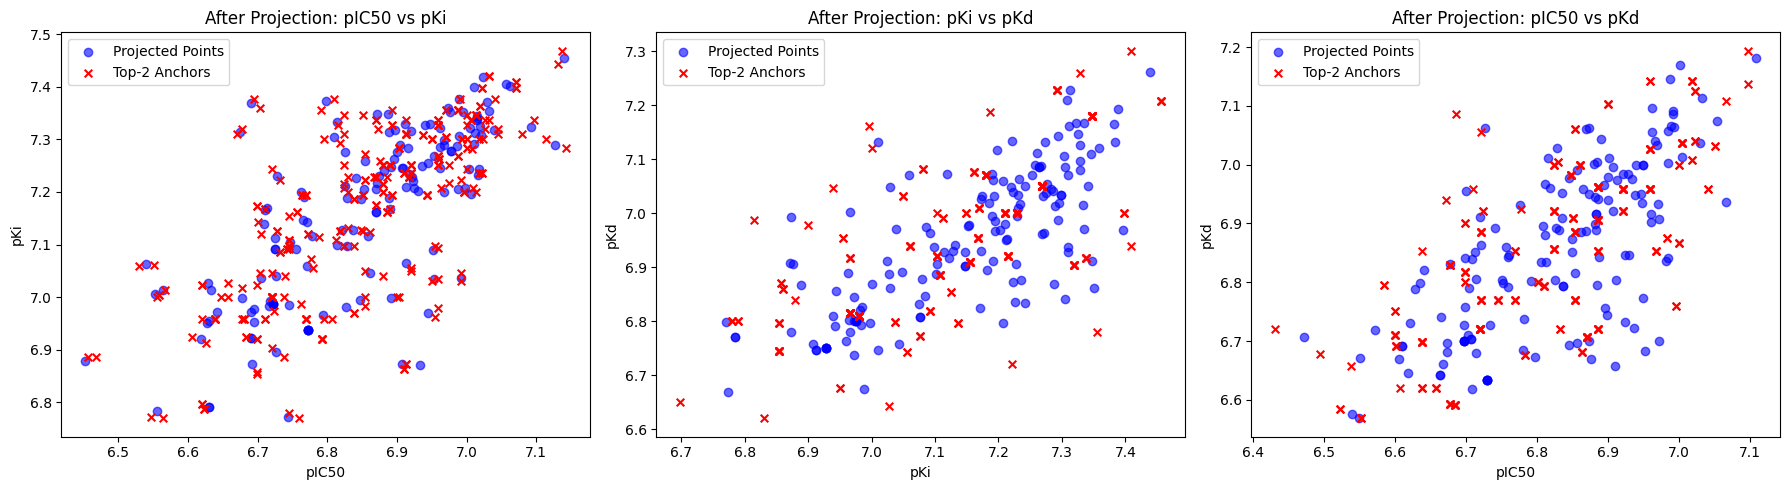

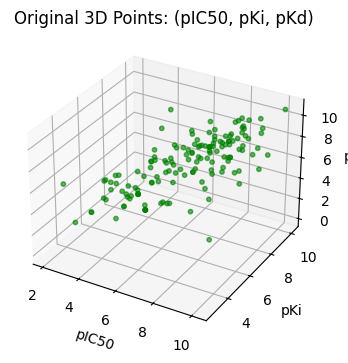

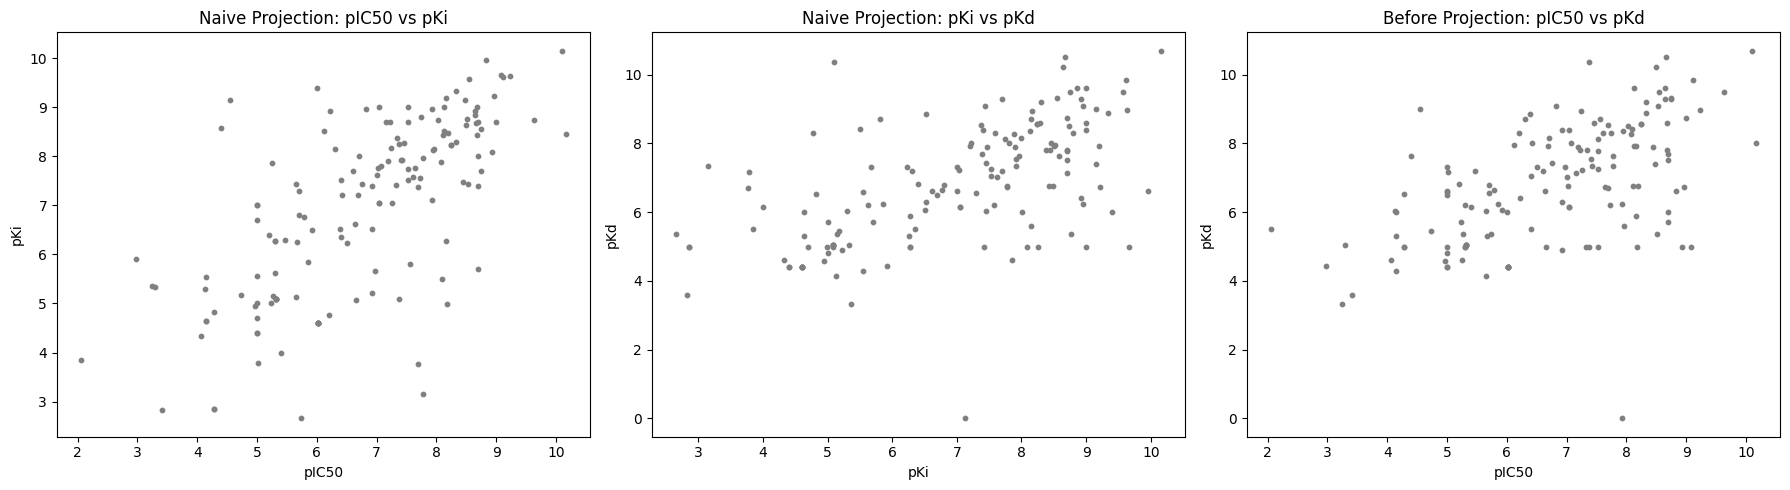

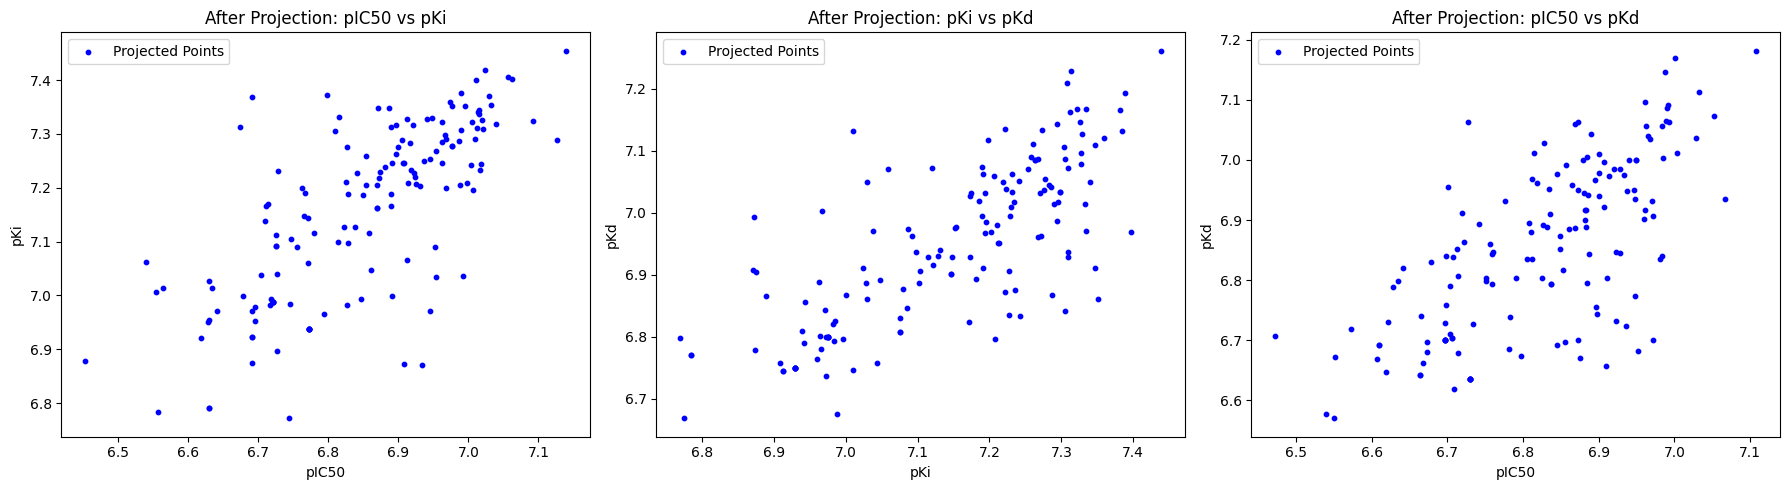

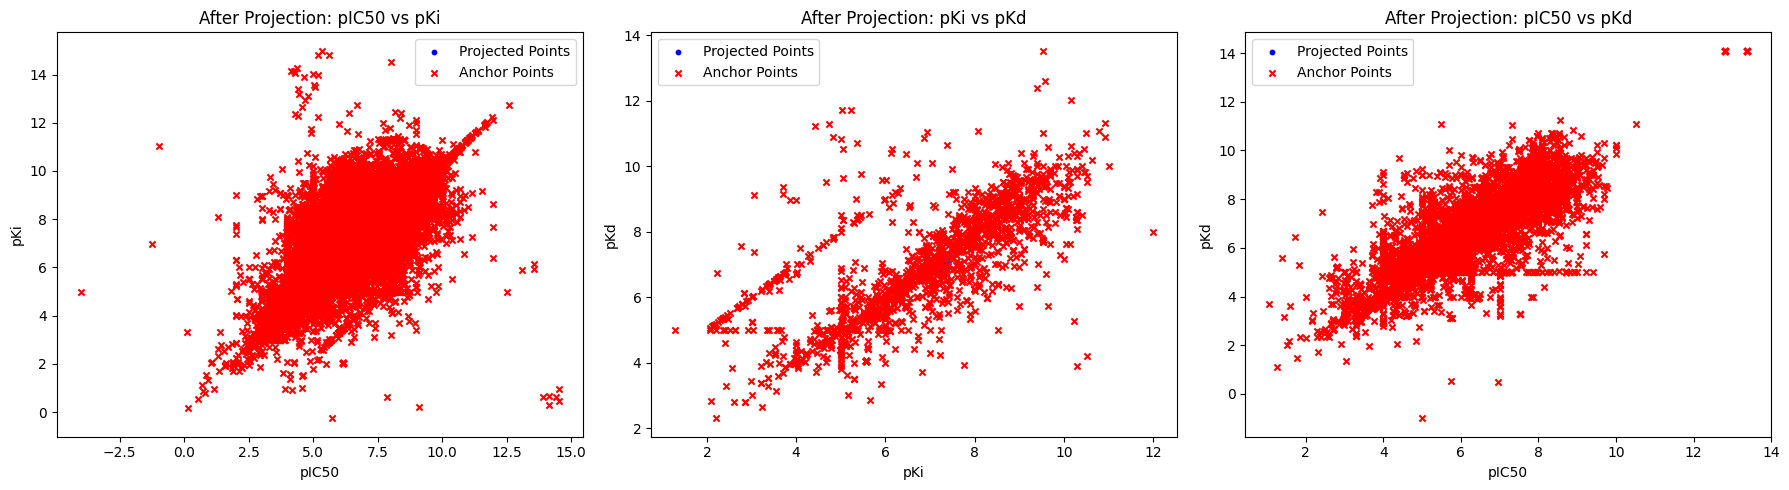

In [5]:
model.eval()
all_data = torch.stack([test_dataset[i] for i in range(len(test_dataset))])
# all_data = torch.stack([train_dataset[i] for i in range(len(train_dataset))])
with torch.no_grad():
    out_xy, out_yz, out_zx = model(all_data)

original_3d = all_data.numpy() 
proj_xy_np = out_xy.numpy()
proj_yz_np = out_yz.numpy()
proj_zx_np = out_zx.numpy()

rows = []
for i in range(len(original_3d)):
    for j in range(i + 1, len(original_3d)):
        dist_3d = np.linalg.norm(original_3d[i] - original_3d[j])
        dist_xy = np.linalg.norm(proj_xy_np[i] - proj_xy_np[j])
        dist_yz = np.linalg.norm(proj_yz_np[i] - proj_yz_np[j])
        dist_zx = np.linalg.norm(proj_zx_np[i] - proj_zx_np[j])
        ratio_xy = dist_xy / (dist_3d + 1e-8)
        ratio_yz = dist_yz / (dist_3d + 1e-8)
        ratio_zx = dist_zx / (dist_3d + 1e-8)
        rows.append([
            i, j,
            tuple(original_3d[i]), tuple(original_3d[j]),
            tuple(proj_xy_np[i]), tuple(proj_xy_np[j]),
            tuple(proj_yz_np[i]), tuple(proj_yz_np[j]),
            tuple(proj_zx_np[i]), tuple(proj_zx_np[j]),
            dist_3d, dist_xy, dist_yz, dist_zx,
            ratio_xy, ratio_yz, ratio_zx
        ])

header = [
    "idx_i", "idx_j",
    "orig_coords_i", "orig_coords_j",
    "proj_xy_coords_i", "proj_xy_coords_j",
    "proj_yz_coords_i", "proj_yz_coords_j",
    "proj_zx_coords_i", "proj_zx_coords_j",
    "dist_3d", "dist_xy", "dist_yz", "dist_zx",
    "ratio_xy", "ratio_yz", "ratio_zx"
]

# csv_path = "/home/amit/Aging_project/projection_distances.csv"
# with open(csv_path, mode='w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)
#     writer.writerows(rows)

# print(f"CSV saved to: {csv_path}")


def plot_projection_with_top2(proj_points, anchor_points, title, xlabel, ylabel):
    plt.scatter(proj_points[:, 0], proj_points[:, 1], alpha=0.6, label="Projected Points", color="blue")

    for p in proj_points:
        if len(anchor_points) > 0:
            dists = np.linalg.norm(anchor_points - p, axis=1)
            top2_idx = np.argsort(dists)[:2]
            plt.scatter(anchor_points[top2_idx, 0], anchor_points[top2_idx, 1],
                        c='red', marker='x', s=30, label="Top-2 Anchors" if "Top-2 Anchors" not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plot_projection_with_top2(proj_xy_np, anchor_xy, "After Projection: pIC50 vs pKi", "pIC50", "pKi")

plt.subplot(1, 3, 2)
plot_projection_with_top2(proj_yz_np, anchor_yz, "After Projection: pKi vs pKd", "pKi", "pKd")

plt.subplot(1, 3, 3)
plot_projection_with_top2(proj_zx_np, anchor_zx, "After Projection: pIC50 vs pKd", "pIC50", "pKd")

plt.tight_layout()
plt.show()


#3D plots
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(original_3d[:, 0], original_3d[:, 1], original_3d[:, 2], c='green', s=10, alpha=0.6)
ax.set_xlabel('pIC50')
ax.set_ylabel('pKi')
ax.set_zlabel('pKd')
ax.set_title("Original 3D Points: (pIC50, pKi, pKd)")
plt.show()

#Actual co-ordinates
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(original_3d[:, 0], original_3d[:, 1], color='gray', s=10)
plt.title("Naive Projection: pIC50 vs pKi")
plt.xlabel("pIC50")
plt.ylabel("pKi")

plt.subplot(1, 3, 2)
plt.scatter(original_3d[:, 1], original_3d[:, 2], color='gray', s=10)
plt.title("Naive Projection: pKi vs pKd")
plt.xlabel("pKi")
plt.ylabel("pKd")

plt.subplot(1, 3, 3)
plt.scatter(original_3d[:, 0], original_3d[:, 2], color='gray', s=10)
plt.title("Before Projection: pIC50 vs pKd")
plt.xlabel("pIC50")
plt.ylabel("pKd")

plt.tight_layout()
plt.show()

#Projected points
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(out_xy[:, 0], out_xy[:, 1], color='blue', s=10, label="Projected Points")
plt.title("After Projection: pIC50 vs pKi")
plt.xlabel("pIC50")
plt.ylabel("pKi")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(out_yz[:, 0], out_yz[:, 1], color='blue', s=10, label="Projected Points")
plt.title("After Projection: pKi vs pKd")
plt.xlabel("pKi")
plt.ylabel("pKd")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(out_zx[:, 0], out_zx[:, 1], color='blue', s=10, label="Projected Points")
plt.title("After Projection: pIC50 vs pKd")
plt.xlabel("pIC50")
plt.ylabel("pKd")
plt.legend()

plt.tight_layout()
plt.show()

#Projected points with anchor points
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(out_xy[:, 0], out_xy[:, 1], color='blue', s=10, label="Projected Points")
if len(anchor_xy) > 0:
    plt.scatter(anchor_xy[:, 0], anchor_xy[:, 1], color='red', marker='x', label="Anchor Points", s=20)
plt.title("After Projection: pIC50 vs pKi")
plt.xlabel("pIC50")
plt.ylabel("pKi")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(out_yz[:, 0], out_yz[:, 1], color='blue', s=10, label="Projected Points")
if len(anchor_yz) > 0:
    plt.scatter(anchor_yz[:, 0], anchor_yz[:, 1], color='red', marker='x', label="Anchor Points", s=20)
plt.title("After Projection: pKi vs pKd")
plt.xlabel("pKi")
plt.ylabel("pKd")
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(out_zx[:, 0], out_zx[:, 1], color='blue', s=10, label="Projected Points")
if len(anchor_zx) > 0:
    plt.scatter(anchor_zx[:, 0], anchor_zx[:, 1], color='red', marker='x', label="Anchor Points", s=20)
plt.title("After Projection: pIC50 vs pKd")
plt.xlabel("pIC50")
plt.ylabel("pKd")
plt.legend()

plt.tight_layout()
plt.show()


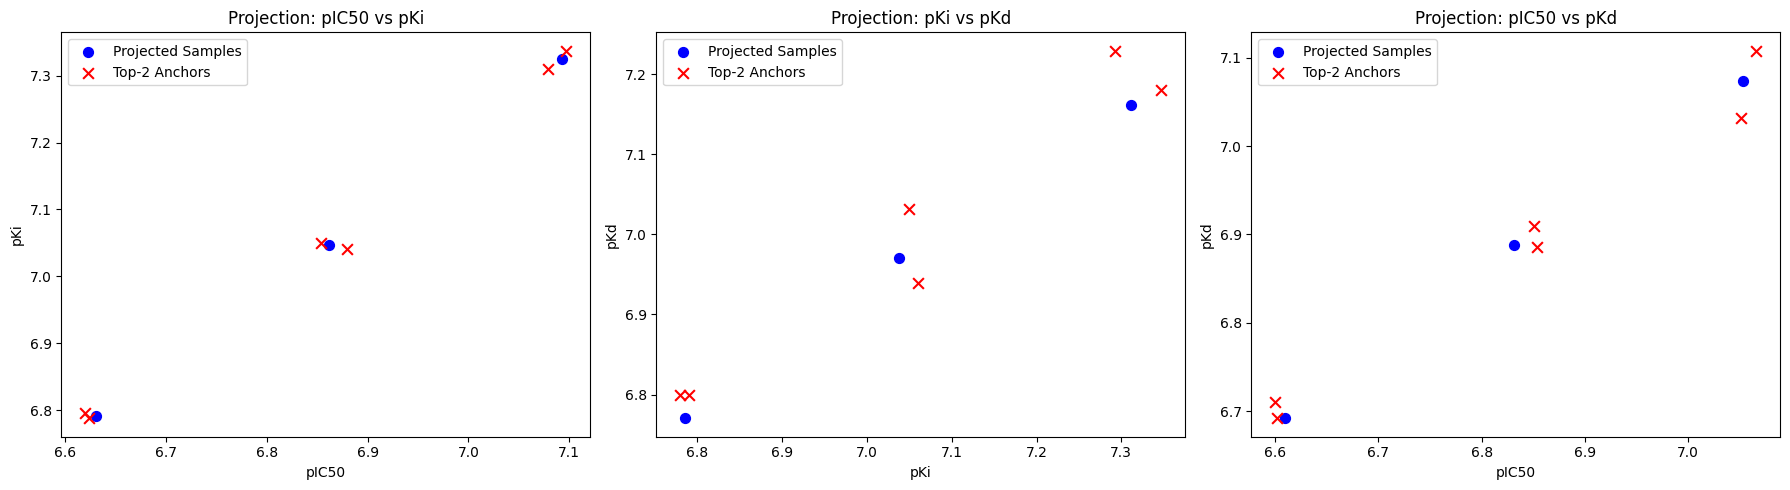

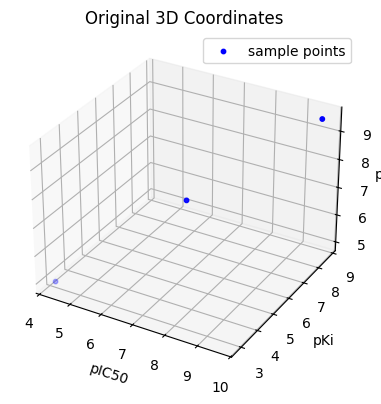

In [6]:
def plot_projection(sample_indices, proj_points, anchor_points, title, xlabel, ylabel):
    selected_proj = proj_points[sample_indices]

    plt.scatter(selected_proj[:, 0], selected_proj[:, 1], c='blue', s=50, label="Projected Samples")

    for p in selected_proj:
        if len(anchor_points) > 0:
            dists = np.linalg.norm(anchor_points - p, axis=1)
            top2_idx = np.argsort(dists)[:2]
            plt.scatter(anchor_points[top2_idx, 0], anchor_points[top2_idx, 1],
                        c='red', marker='x', s=60, label="Top-2 Anchors" if "Top-2 Anchors" not in plt.gca().get_legend_handles_labels()[1] else "")
            # for idx in top2_idx:
            #     plt.plot([p[0], anchor_points[idx, 0]], [p[1], anchor_points[idx, 1]], 'k--', alpha=0.5)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

sample_indices = [0,1,2]  

model.eval()
all_data = torch.stack([test_dataset[i] for i in range(len(test_dataset))])
with torch.no_grad():
    proj_xy, proj_yz, proj_zx = model(all_data)

proj_xy_np = proj_xy.numpy()
proj_yz_np = proj_yz.numpy()
proj_zx_np = proj_zx.numpy()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plot_projection(sample_indices, proj_xy_np, anchor_xy, "Projection: pIC50 vs pKi", "pIC50", "pKi")
plt.subplot(1, 3, 2)
plot_projection(sample_indices, proj_yz_np, anchor_yz, "Projection: pKi vs pKd", "pKi", "pKd")
plt.subplot(1, 3, 3)
plot_projection(sample_indices, proj_zx_np, anchor_zx, "Projection: pIC50 vs pKd", "pIC50", "pKd")
plt.tight_layout()
plt.show()

original_3d = all_data.numpy()
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(original_3d[:, 0], original_3d[:, 1], original_3d[:, 2], c='lightgray', s=10, alpha=0.4, label="All Points")
ax.scatter(original_3d[sample_indices, 0], original_3d[sample_indices, 1], original_3d[sample_indices, 2],
           c='blue', s=10, label="sample points")
ax.set_xlabel('pIC50')
ax.set_ylabel('pKi')
ax.set_zlabel('pKd', labelpad=1)
ax.set_title("Original 3D Coordinates")
ax.legend()
plt.tight_layout()
plt.show()


In [7]:
# ==================== Masked-vs-Projected Distances + Correlation ====================


def distances_and_corr_for_plane(original_3d, proj2d, anchors2d, plane_name, top_k=2, do_plot=False):
    """
    For a plane (xy/yz/zx):
      - mask original 3D coords to that plane (2D)
      - compute distances from masked originals to anchors (Dist_orig)
      - compute distances from projected points to anchors (Dist_proj)
      - keep top-k nearest anchors per point (by masked original distance)
      - return a DataFrame and Pearson correlation between Dist_orig and Dist_proj
    """
    if anchors2d is None or len(anchors2d) == 0:
        print(f"[WARN] No anchors for plane {plane_name.upper()}, skipping.")
        return None, np.nan

    # Mask original 3D to the plane (select 2 axes)
    if plane_name == "xy":        # pIC50 vs pKi
        orig2d = original_3d[:, [0, 1]]
        xlab, ylab = "pIC50", "pKi"
    elif plane_name == "yz":      # pKi vs pKd
        orig2d = original_3d[:, [1, 2]]
        xlab, ylab = "pKi", "pKd"
    elif plane_name == "zx":      # pIC50 vs pKd
        orig2d = original_3d[:, [0, 2]]
        xlab, ylab = "pIC50", "pKd"
    else:
        raise ValueError("plane_name must be one of {'xy','yz','zx'}")

    N = orig2d.shape[0]
    M = anchors2d.shape[0]
    k = int(min(top_k, M))
    if k <= 0:
        print(f"[WARN] top_k <= 0 or no anchors for {plane_name.upper()}, skipping.")
        return None, np.nan

    # Distances: masked-original -> anchors and projected -> anchors  (both [N, M])
    D_orig = np.linalg.norm(orig2d[:, None, :] - anchors2d[None, :, :], axis=2)
    D_proj = np.linalg.norm(proj2d[:, None, :] - anchors2d[None, :, :], axis=2)

    # Top-k nearest anchors per point using masked-original distance
    nn_idx = np.argpartition(D_proj, kth=k-1, axis=1)[:, :k]  # [N, k]

    rows, col_orig, col_proj = [], [], []
    for i in range(N):
        for j in nn_idx[i]:
            rows.append([
                i, int(j),
                orig2d[i, 0], orig2d[i, 1],
                proj2d[i, 0], proj2d[i, 1],
                anchors2d[j, 0], anchors2d[j, 1],
                D_orig[i, j], D_proj[i, j]
            ])
            col_orig.append(D_orig[i, j])
            col_proj.append(D_proj[i, j])

    df = pd.DataFrame(
        rows,
        columns=[
            "point_idx", "anchor_idx",
            f"orig_{xlab}", f"orig_{ylab}",
            "proj_x", "proj_y",
            "anchor_x", "anchor_y",
            "dist_orig_masked", "dist_proj"
        ],
    )

    # Pearson correlation
    if len(col_orig) > 1 and np.std(col_orig) > 0 and np.std(col_proj) > 0:
        r = float(np.corrcoef(col_orig, col_proj)[0, 1])
    else:
        r = np.nan

    print(
        f"[{plane_name.upper()}] Pearson r(masked-original & anchor, projected & anchor) "
        f"with top_k={k}: {r:.4f}"
    )

    if do_plot:
        plt.figure(figsize=(4.2, 4.2))
        plt.scatter(col_orig, col_proj, s=12, alpha=0.6)
        plt.xlabel("Distance (original masked & anchor)")
        plt.ylabel("Distance (projected & anchor)")
        plt.title(f"{plane_name.upper()} distances: r={r:.3f}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return df, r


[XY] Pearson r(masked-original & anchor, projected & anchor) with top_k=2: 0.0522


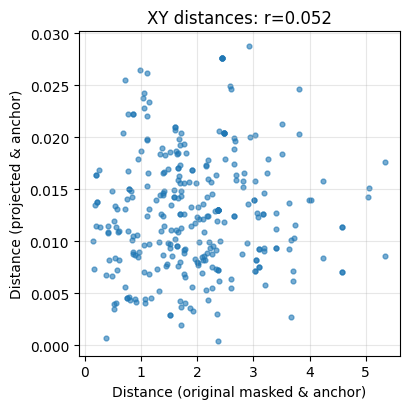

[YZ] Pearson r(masked-original & anchor, projected & anchor) with top_k=2: 0.2681


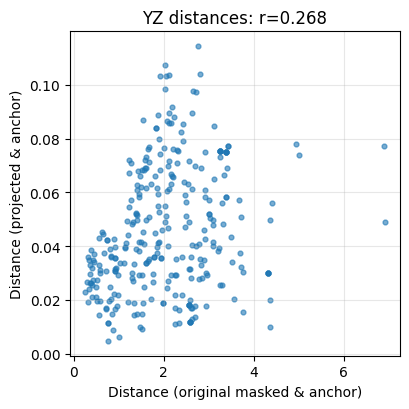

[ZX] Pearson r(masked-original & anchor, projected & anchor) with top_k=2: 0.1956


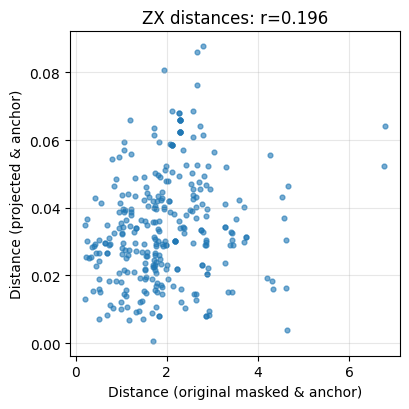

masked_vs_projected_anchor_distances Saved to: /home/amit/Aging_project/masked_vs_projected_anchor_distances_sigma_1.csv


In [8]:
TOP_K = 2

df_xy_corr, r_xy = distances_and_corr_for_plane(
    original_3d, proj_xy_np, anchor_xy, plane_name="xy", top_k=TOP_K, do_plot=True
)
df_yz_corr, r_yz = distances_and_corr_for_plane(
    original_3d, proj_yz_np, anchor_yz, plane_name="yz", top_k=TOP_K, do_plot=True
)
df_zx_corr, r_zx = distances_and_corr_for_plane(
    original_3d, proj_zx_np, anchor_zx, plane_name="zx", top_k=TOP_K, do_plot=True
)

dfs_to_save = [d for d in [df_xy_corr, df_yz_corr, df_zx_corr] if d is not None]
if len(dfs_to_save) > 0:
    df_all = pd.concat(dfs_to_save, keys=["xy", "yz", "zx"], names=["plane", "row"])
    csv_path_corr = "/home/amit/Aging_project/masked_vs_projected_anchor_distances_sigma_1.csv"
    df_all.to_csv(csv_path_corr)
    print(f"masked_vs_projected_anchor_distances Saved to: {csv_path_corr}")


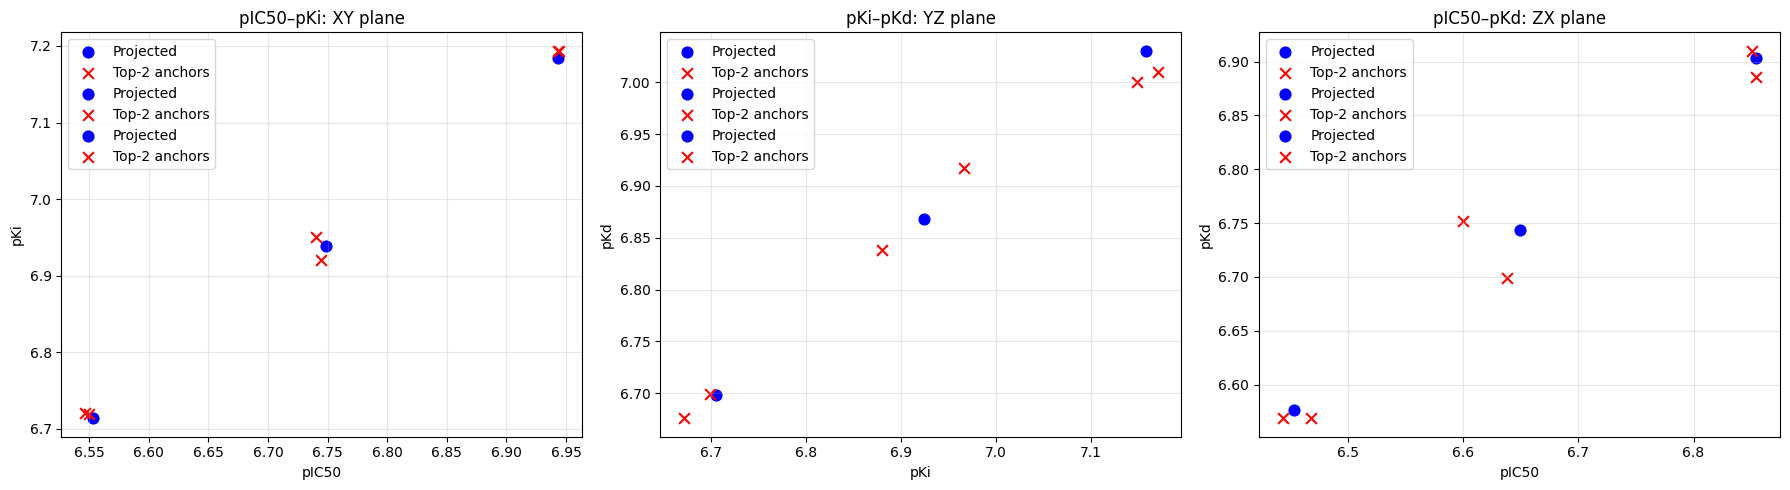

In [24]:
def _masked2d(original_3d, plane):
    if plane == "xy":      
        return original_3d[:, [0, 1]], "pIC50", "pKi"
    elif plane == "yz":    
        return original_3d[:, [1, 2]], "pKi", "pKd"
    elif plane == "zx":    
        return original_3d[:, [0, 2]], "pIC50", "pKd"
    else:
        raise ValueError("plane must be 'xy', 'yz', or 'zx'")

def _has_label(ax, label):
    return (ax.legend_ is not None) and (label in [t.get_text() for t in ax.legend_.texts])

def plot_samples_with_anchors_and_masked(ax, original_3d, proj2d, anchors2d, plane,
                                         sample_indices, top_k=2, title_prefix=""):
    if anchors2d is None or len(anchors2d) == 0:
        ax.set_title(f"{title_prefix}{plane.upper()} (no anchors)")
        return

    masked2d, xl, yl = _masked2d(original_3d, plane)

    # all anchors
    # ax.scatter(anchors2d[:, 0], anchors2d[:, 1], c="red", marker="x", s=25, alpha=0.25,
    #            label="All anchors" if not _has_label(ax, "All anchors") else None)

    for si in sample_indices:
        p_mask = masked2d[si]        
        p_proj = proj2d[si]          

        dists = np.linalg.norm(anchors2d - p_proj, axis=1)
        k = min(top_k, len(anchors2d))
        top_idx = np.argsort(dists)[:k]

        # ax.scatter([p_mask[0]], [p_mask[1]], c="gray", s=60, marker="s",
        #            label="Masked original" if not _has_label(ax, "Masked original") else None)

        # projected 
        ax.scatter([p_proj[0]], [p_proj[1]], c="blue", s=60,
                   label="Projected" if not _has_label(ax, "Projected") else None)

        
        ax.scatter(anchors2d[top_idx, 0], anchors2d[top_idx, 1],
                   c="red", marker="x", s=60,
                   label=f"Top-{k} anchors" if not _has_label(ax, f"Top-{k} anchors") else None)

        # connect projected & anchors
        # for j in top_idx:
        #     ax.plot([p_proj[0], anchors2d[j, 0]], [p_proj[1], anchors2d[j, 1]],
        #             "r--", alpha=0.5, linewidth=1)

        # connect masked original & projected
        # ax.plot([p_mask[0], p_proj[0]], [p_mask[1], p_proj[1]],
        #         "k:", alpha=0.7, linewidth=1)

    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(f"{title_prefix}{plane.upper()} plane")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)

SAMPLE_INDICES = [0, 1, 2]   
TOP_K = 2

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_samples_with_anchors_and_masked(
    axes[0], original_3d, proj_xy_np, anchor_xy, plane="xy",
    sample_indices=SAMPLE_INDICES, top_k=TOP_K, title_prefix="pIC50–pKi: "
)
plot_samples_with_anchors_and_masked(
    axes[1], original_3d, proj_yz_np, anchor_yz, plane="yz",
    sample_indices=SAMPLE_INDICES, top_k=TOP_K, title_prefix="pKi–pKd: "
)
plot_samples_with_anchors_and_masked(
    axes[2], original_3d, proj_zx_np, anchor_zx, plane="zx",
    sample_indices=SAMPLE_INDICES, top_k=TOP_K, title_prefix="pIC50–pKd: "
)
plt.tight_layout()
plt.show()
